# Predicting House Prices

Before I get into modeling, I want to start by looking through the data a bit.


In [21]:
import pandas as pd
import matplotlib as mp
%matplotlib inline

data_frame = pd.read_table("./housing.data", sep='\s+', header=None)
data_frame[0:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Unfortunately, unlike most datasets I've worked with, all I know for this set is which field is price (the last one, 13).  I'm not confident of what the others represent, so it's hard to hypothesize initially about which columns will be relevant. For this simple model I'll probably just include them all.  I do want to quickly visualize what the distribution of house prices (which I believe are in 10-thousands) looks like.

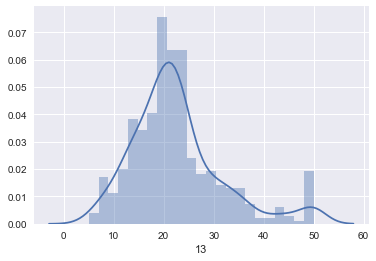

In [22]:
prices = data_frame[13]
import seaborn as sns
sns.distplot(prices)

At this point I considered centering and scaling the features in the dataset, but given this is really an exercise I'm using to better internalize the tensorflow interface, I'm going to give it a whirl and see how it performs without preprocessing.  Instead I'm going to go write to shuffling and splitting the data into a test set and a training set.

In [36]:
import sklearn.model_selection

data = data_frame.as_matrix()
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, train_size=0.9,random_state=2468)

print(len(train))
print(len(test))

455
51


In [47]:
# extract x and y features
price_column = 13
train_x = train[:,0:price_column]
train_y = train[:,[price_column]]
test_x = test[:,0:price_column]
test_y = test[:,[price_column]]

At this point I have the data in a trainable format, now I'm going to try applying tensorflo by picking a learning rate and setting up some placeholders for the data and target (and some weights for the matrix multiplication, initialized to be quite small).

In [164]:
import tensorflow as tf

learning_rate = 0.001
training_epochs = 100000
training_dimensions = len(train_x[0])
features = tf.placeholder(tf.float32, [None, training_dimensions])
labels = tf.placeholder(tf.float32, [None, 1])
weights = tf.Variable(tf.ones([training_dimensions, 1]))
bias = tf.Variable(tf.zeros([1]))


Now to define the operations I'll walk through for each epoch to train the model:

In [165]:
predictions = tf.add(tf.matmul(features, weights), bias)
cost_function = tf.reduce_mean(tf.square(labels - predictions))
training_step = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

And now we can open up the session and walk the above operations for each epoch

In [ ]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

# data is small enough we can feed the whole set through each time
dictionary = {features: train_x, labels: train_y}
for epoch in range(training_epochs):
    session.run(training_step, feed_dict=dictionary)
    current_cost = session.run(cost_function, feed_dict=dictionary)
    if epoch % 10000 == 0:
        print("epoch ", epoch, "; current cost: ", current_cost)

print("Final Cost", session.run(cost_function, feed_dict=dictionary))

epoch  0 ; current cost:  828409.0
epoch  10000 ; current cost:  49.8006


In [161]:
test_predictions = session.run(predictions, feed_dict={features: test_x, labels: test_y})
train_predictions = session.run(predictions, feed_dict={features: train_x, labels: train_y})
session.close()

Now we can compare the predictions on the reserved test set to the actual labels

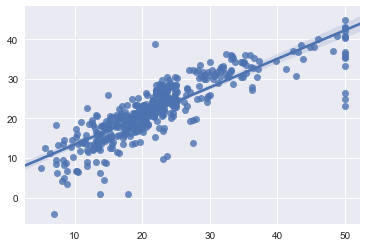

In [162]:
train_outputs = train_predictions.reshape(-1)
sns.regplot(train_y, train_outputs)

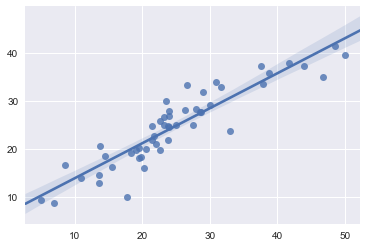

In [163]:

outputs = test_predictions.reshape(-1)
sns.regplot(test_y, outputs)

The result seems to hold well, at least for this small dataset.  Since the y-axis in this final plot is the "predicted" value (with the a-axis being the real value) you can see that the model predicts a bit high at the low end of the distribution, and a bit low at the high end.  